##**Movie Recommender System using TF-IDF method of Text Vectorization**

In [3]:
!pip install -q kaggle


#### ***Prepping environment for downloading dataset from Kaggle***

In [4]:


from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"flash6237","key":"36ae8a62fda80db3917b65296555bd64"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle datasets list

In [7]:
# Downloading the dataset

! kaggle datasets download -d tmdb/tmdb-movie-metadata

 56% 5.00M/8.89M [00:00<00:00, 35.6MB/s]
100% 8.89M/8.89M [00:00<00:00, 58.0MB/s]


In [8]:
# Unzipping the files

!unzip "/content/tmdb-movie-metadata.zip"

Archive:  /content/tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


#### ***Making the required imports***

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [11]:
df = pd.read_csv("tmdb_5000_movies.csv")

In [38]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,category_type
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Fantasy Action Adventure and Fantasy Action Ad...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Fantasy Action Adventure and Fantasy Action Ad...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Fantasy Action Adventure and Fantasy Action Ad...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Fantasy Action Adventure and Fantasy Action Ad...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Fantasy Action Adventure and Fantasy Action Ad...


In [ ]:
# We need only the genres and keywords for recommending movies

x = df.iloc[5]
x, type(x)

In [17]:
x['genres']

'[{"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]'

In [25]:
x['genres'],type(x['genres'])

('[{"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]',
 str)

In [18]:
x['keywords']

'[{"id": 851, "name": "dual identity"}, {"id": 1453, "name": "amnesia"}, {"id": 1965, "name": "sandstorm"}, {"id": 2038, "name": "love of one\'s life"}, {"id": 3446, "name": "forgiveness"}, {"id": 3986, "name": "spider"}, {"id": 4391, "name": "wretch"}, {"id": 4959, "name": "death of a friend"}, {"id": 5776, "name": "egomania"}, {"id": 5789, "name": "sand"}, {"id": 5857, "name": "narcism"}, {"id": 6062, "name": "hostility"}, {"id": 8828, "name": "marvel comic"}, {"id": 9663, "name": "sequel"}, {"id": 9715, "name": "superhero"}, {"id": 9748, "name": "revenge"}]'

In [27]:
# Converting the json objects to list of dictionaries
j = json.loads(x['genres'])
j, type(j), type(j[0])

([{'id': 14, 'name': 'Fantasy'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 list,
 dict)

In [29]:
' '.join(''.join(category['name'].split()) for category in j )

'Fantasy Action Adventure'

#### ***Convert all the genres of each film into a single string***

In [54]:
# to be used by TfidfVectorizer

def get_genres_and_keywords(row):
  genres = json.loads(row['genres'])
  genres = ' '.join(''.join(category['name'].split()) for category in genres )

  keywords = json.loads(row['keywords'])
  keywords = ' '.join(''.join(category['name'].split()) for category in keywords )

  return "%s %s" %(genres, keywords)


In [55]:
# Creating string representation of genres for each movie 

df['category_type'] = df.apply(get_genres_and_keywords, axis=1)

In [56]:
df['category_type'][5]

"Fantasy Action Adventure dualidentity amnesia sandstorm loveofone'slife forgiveness spider wretch deathofafriend egomania sand narcism hostility marvelcomic sequel superhero revenge"

In [57]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,category_type
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action Adventure Fantasy ScienceFiction cultur...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure Fantasy Action ocean drugabuse exoti...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Action Adventure Crime spy basedonnovel secret...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Action Crime Drama Thriller dccomics crimefigh...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Action Adventure ScienceFiction basedonnovel m...


### **Creating TF-IDF Vectorizer**

In [58]:
tfidf = TfidfVectorizer(max_features=3000)

In [59]:
# Creating data matrix
X = tfidf.fit_transform(df['category_type'])

In [60]:
X

<4803x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 40451 stored elements in Compressed Sparse Row format>

#### **Generating mapping from Movie_title -> Index**

In [61]:
movie2idx = pd.Series(df.index, index = df['title'])
movie2idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [62]:
idx = movie2idx['Interstellar']
idx

95

In [63]:
query = X[idx]
query

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 31 stored elements in Compressed Sparse Row format>

In [64]:
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

### **Computing similarity between queried movie and other movies in dataset**

In [66]:
 ## Computing cosine similarity between query and vector in X
 scores = cosine_similarity(query, X)
 scores

array([[0.08750067, 0.00808549, 0.01596951, ..., 0.00476374, 0.        ,
        0.        ]])

In [69]:
# Flattening the scores array to 1D array

scores = scores.flatten()

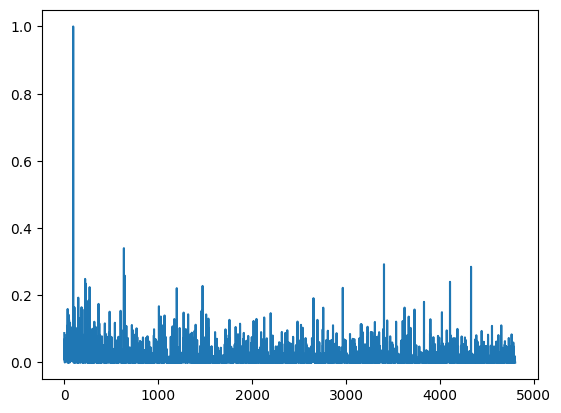

In [70]:
plt.plot(scores)

In [71]:
# Getting top 5 matches

(-scores).argsort()

array([  95,  635, 3405, ..., 2510, 2477, 4802])

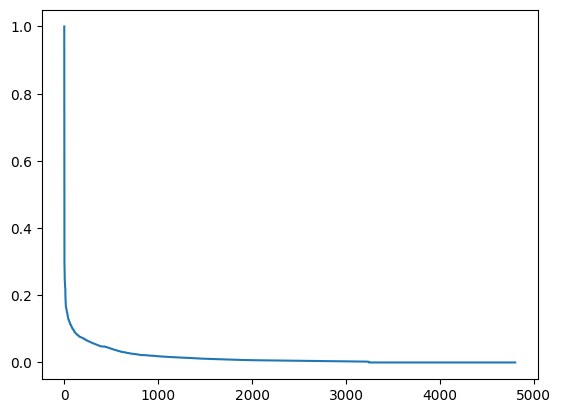

In [72]:
plt.plot(scores[(-scores).argsort()])

In [74]:
# Querying from 1 to exclude the queried movie itself
recommended_idx = (-scores).argsort()[1:6]

In [75]:
# Getting movie titles from recommended movie indices
df['title'].iloc[recommended_idx] 

635                      Apollo 13
3405    Stargate: The Ark of Truth
4332                Silent Running
643                  Space Cowboys
222                        Elysium
Name: title, dtype: object

### **Creating a function that recommends movies**

In [90]:
# Takes in the title of a movie and returns 'n' similar movies from the database
def movie_recommend(title, n):
  idx = movie2idx[title]
  recommended_idx = []

  if type(idx) == pd.Series:
    
    idx = idx.iloc[0]

    query = X[idx]
    scores = cosine_similarity(query, X)
    print(scores)

    scores = scores.flatten()
    recommended_idx = (-scores).argsort()[1:(n+1)]

    return df['title'].iloc[recommended_idx]

  else:

    query = X[idx]
    scores = cosine_similarity(query, X)

    scores = scores.flatten()

    recommended_idx = (-scores).argsort()[1:(n+1)]

    return df['title'].iloc[recommended_idx]

## **Movie recommender query from users**

In [104]:
name = input('Enter a movie name that you want recommendations for: ')
no = int(input('Enter the no. of recommendations you want: '))

try:
  recommended_movies = movie_recommend(name, no)
  print(f'Your recommendations for {name} are: ')
  for i in recommended_movies:
    print(i)
except:
  print("The movie is not in our database, try a different movie or check the spelling")

Enter a movie name that you want recommendations for: The Notebook
Enter the no. of recommendations you want: 5
Your recommendations for The Notebook are: 
Two Lovers
You, Me and Dupree
Wicker Park
Children of Heaven
Kate & Leopold
